## BERT for question/answering

In [1]:
from transformers import BertTokenizerFast, BertForQuestionAnswering, pipeline, \
                         DataCollatorWithPadding, TrainingArguments, Trainer, \
                         AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

In [2]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased', return_token_type_ids=True)

qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased

In [3]:
qa_df = pd.read_csv('../data/qa.csv')

qa_df.shape

(29989, 5)

In [4]:
qa_df.head()

,question,context,start_positions,end_positions,answer
0,What sare the benifts of the blood brain barrir?,Another approach to brain function is to exami...,56,60,isolated from the bloodstream
1,What is surrounded by cerebrospinal fluid?,Another approach to brain function is to exami...,16,16,brain
2,What does the skull protect?,Another approach to brain function is to exami...,11,11,brain
3,What has been injected into rats to produce pr...,Another approach to brain function is to exami...,153,153,chemicals
4,What can cause issues with how the brain works?,Another approach to brain function is to exami...,93,94,brain damage


In [5]:
qa_df.iloc[0]

question            What sare the benifts of the blood brain barrir?
context            Another approach to brain function is to exami...
start_positions                                                   56
end_positions                                                     60
answer                                 isolated from the bloodstream
Name: 0, dtype: object

In [6]:
# index 56, 57, 58, 59, and 60 including question while encoding
bert_tokenizer.decode(bert_tokenizer.encode(qa_df.iloc[0].question, qa_df.iloc[0].context)[56:61])

'isolated from the bloodstream'

In [7]:
# only grab 1,000 examples
qa_dataset = Dataset.from_pandas(qa_df.sample(1000, random_state=42))

# Dataset has a built in train test split method
qa_dataset = qa_dataset.train_test_split(test_size=0.2)

In [8]:
# standard preprocessing here with truncation on to truncate longer text
def preprocess(data):
    return bert_tokenizer(data['question'], data['context'], truncation=True)

qa_dataset = qa_dataset.map(preprocess, batched=True)

Parameter 'function'=<function preprocess at 0x7fb2ccabedc0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [9]:
# freeze all but the last 2 encoder layers in BERT to speed up training
for name, param in qa_bert.bert.named_parameters():
    if 'encoder.layer.22' in name:
        break
    param.requires_grad = False  # disable training in BERT

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [11]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./qa/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./qa/logs',
    save_strategy='epoch',
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=qa_bert,
    args=training_args,
    train_dataset=qa_dataset['train'],
    eval_dataset=qa_dataset['test'],
    data_collator=data_collator
)

# Get initial metrics
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: context, question, answer, __index_level_0__. If context, question, answer, __index_level_0__ are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


{'eval_loss': 5.898818492889404,
 'eval_runtime': 1185.5435,
 'eval_samples_per_second': 0.169,
 'eval_steps_per_second': 0.006}

In [12]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: context, question, answer, __index_level_0__. If context, question, answer, __index_level_0__ are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Epoch,Training Loss,Validation Loss
1,5.223300,4.926177
2,4.735700,4.748297


The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: context, question, answer, __index_level_0__. If context, question, answer, __index_level_0__ are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
Saving model checkpoint to ./qa/results/checkpoint-25
Configuration saved in ./qa/results/checkpoint-25/config.json
Model weights saved in ./qa/results/checkpoint-25/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: context, question, answer, __index_level_0__. If context, question, answer, __index_level_0__ are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
Saving model checkpo

TrainOutput(global_step=50, training_loss=5.1034912109375, metrics={'train_runtime': 13859.0961, 'train_samples_per_second': 0.115, 'train_steps_per_second': 0.004, 'total_flos': 1055359408179456.0, 'train_loss': 5.1034912109375, 'epoch': 2.0})

In [13]:
# Q/A models are very large and take a long time to fine-tune

In [14]:
trainer.save_model()

Saving model checkpoint to ./qa/results
Configuration saved in ./qa/results/config.json
Model weights saved in ./qa/results/pytorch_model.bin


In [15]:
pipe = pipeline("question-answering", './qa/results', tokenizer=bert_tokenizer)

loading configuration file ./qa/results/config.json
Model config BertConfig {
  "_name_or_path": "./qa/results",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file ./qa/results/config.json
Model config BertConfig {
  "_name_or_path": "./qa/results",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_che

In [16]:
pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.035303886979818344, 'start': 15, 'end': 25, 'answer': 'California'}

In [17]:
princeton = """In 1675, a Quaker missionary from England, encouraged by New Jersey proprietors John Lord 
              "Berkeley and Sir George Carteret, arrived to establish a settlement in this area near the 
              "Delaware River, which was inhabited by the Lenni-Lenape Indians. The Keith survey of 1685 
              "established the western boundary of Middlesex and Somerset Counties and later, the Township 
              "of Princeton. Today Keith's Line is recognized as Province Line Road. With the laying of the 
              "cornerstone for Nassau Hall in 1754, Princeton began its development as a location for 
              "quality education. Nassau Hall was named for William III, Prince of Orange-Nassau. This simple stone 
              "edifice was one of the largest public buildings in the colonies and became a model for many other 
              "structures in New Jersey and Pennsylvania."""

pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.0003657328779809177,
 'start': 657,
 'end': 694,
 'answer': 'Nassau Hall was named for William III'}

In [18]:
PERSON = 'Sinan Ozdemir'

# Note this is NOT an efficient way to search on google. This is done simply for education purposes
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}').text).get_text()[:512]

pipe(f'Who is {PERSON}?', google_html)

{'score': 0.0004086060798726976,
 'start': 213,
 'end': 270,
 'answer': 'monthPast yearAll resultsAll resultsVerbatimSinan Ozdemir'}

# Finetuning made our model better at our specific dataset but loses quality in general Q/A

In [19]:
# From Huggingface: https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

squad_pipe = pipeline("question-answering", "bert-large-uncased-whole-word-masking-finetuned-squad")

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loa

In [20]:
squad_pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.99244624376297, 'start': 15, 'end': 25, 'answer': 'California'}

In [21]:
squad_pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.3114527761936188,
 'start': 277,
 'end': 293,
 'answer': 'The Keith survey'}

In [26]:
squad_pipe(f'Who is {PERSON}?', google_html)

{'score': 0.30824872851371765,
 'start': 273,
 'end': 304,
 'answer': 'Founder + CTO - Stealth Startup'}

In [29]:
# visualize logits
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

qa_input = large_tokenizer(  # tokenize our example
    "Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.",
    return_tensors='pt'
)

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loa

In [30]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

output = large_qa_bert(**qa_input)  # pass the input through our QA model
output

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loa

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.4601, -6.2255, -7.8363, -7.1762, -8.4660, -6.4108, -6.7524, -8.1289,
         -8.7000, -5.4599,  0.6538, -2.8565, -1.1788,  1.0216,  7.0426, -5.2244,
         -1.3684, -5.9469, -4.9360, -0.0566, -5.4591, -5.4591]],
       grad_fn=<CloneBackward0>), end_logits=tensor([[-1.0355, -5.8719, -5.9027, -7.3427, -5.7653, -6.1145, -6.2080, -5.3895,
         -5.7630, -1.0352, -4.9416, -3.3419, -4.7643, -3.9473,  7.5046, -1.7702,
         -2.6509, -5.6540, -5.9817,  1.0278, -1.0357, -1.0406]],
       grad_fn=<CloneBackward0>), hidden_states=None, attentions=None)

In [31]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())

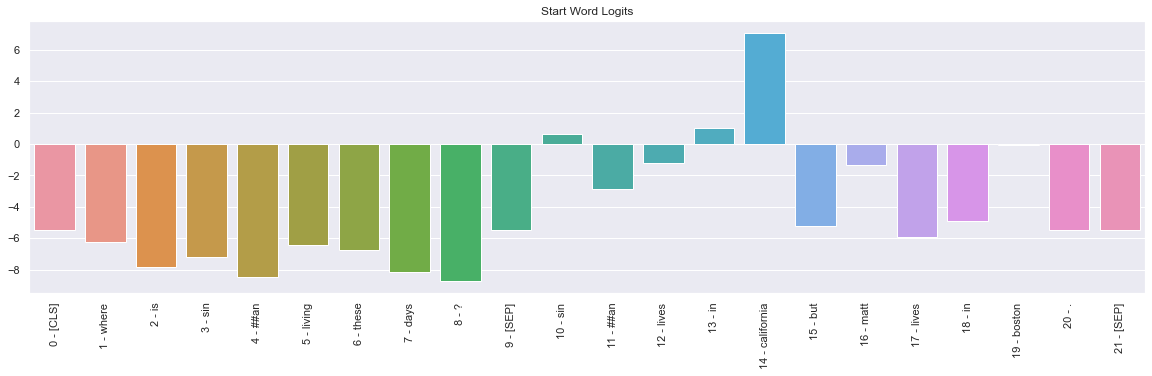

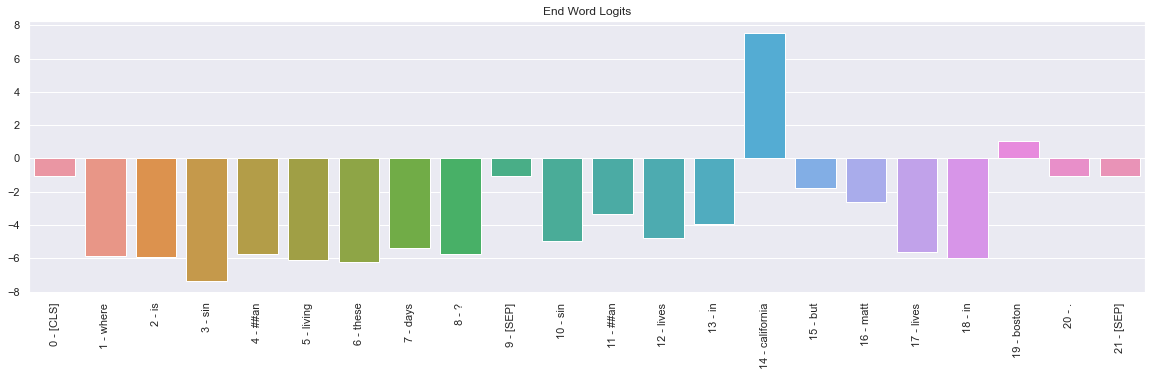

In [32]:
# Plot start and end logits for our fine-tuned model

sns.set(rc={"figure.figsize":(20, 5)}) 

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('Start Word Logits')

plt.show()

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('End Word Logits')

plt.show()